In [1]:
#import 
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from skimage import io
from scipy.optimize import curve_fit
from scipy import optimize
import math
import os
import glob
import re
import pandas as pd 

/home/peter/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
def PMTconversion(low,high,channel):
    #input low and high PMT level, code will calculate the difference in ratio 
    if channel == 2: 
        k = 0.712
    else :
        k = 0.723
    n = 9 
    Ratio = pow(high/low,k*n)
    return Ratio

In [6]:
#read power-angle conversion file
df = pd.read_excel("Power1215.xlsx")
Power = df.to_numpy()

In [12]:
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x) **2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

In [13]:
#fit and plot the lowest power image with gaussian
#just to check the fitting of gaussian for lowest intensity is proper
def fittingcontour(data):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(data,cmap=plt.cm.plasma)
    params = fitgaussian(data)
    fit = gaussian(*params)
    plt.contour(fit(*np.indices(data.shape)), cmap=plt.cm.cool)
    ax = plt.gca()
    (height, x, y, width_x, width_y) = params
    plt.text(0.95, 0.05, """
    height : %.1f
    x : %.1f
    y : %.1f
    width_x : %.1f
    width_y : %.1f""" %(height,y,x, width_x, width_y),
            fontsize=16, horizontalalignment='right',
            verticalalignment='bottom', transform=ax.transAxes,color='w')
    plt.colorbar()
    plt.grid()
    plt.show()

In [27]:
directory_location = "data/12_15/3-1/test1/"

In [28]:
fil = [] #import key arguments from filename
for filename in glob.glob(directory_location + '*.tif'):
    with open(os.path.join(os.getcwd(), filename), 'r') as f :
        fil.append([int(s) for s in re.findall(r'\d+', f.name)])
fil = np.array(fil)
fil = fil[fil[:,0].argsort()]

In [29]:
#since the center of particle maybe affect by the nonlinearity
#I use the lowest intensity center for all intensity 
lowest = io.imread(directory_location + "6_550.tif")#enter the lowest intensity image here 
center = fitgaussian(lowest)[1:3] 
#the first value is y center, the second is x center. 

In [30]:
print(Power)

[[ 6.    7.44]
 [ 8.    7.72]
 [10.    9.26]
 [12.   12.34]
 [14.   16.99]
 [16.   22.73]
 [18.   29.36]
 [20.   37.2 ]
 [22.   45.6 ]
 [24.   55.4 ]
 [26.   65.1 ]
 [28.   75.2 ]
 [30.   85.6 ]]


FileNotFoundError: [Errno 2] No such file or directory: '/home/peter/projects/intensity-analysis/src_ted/12_15.tif'

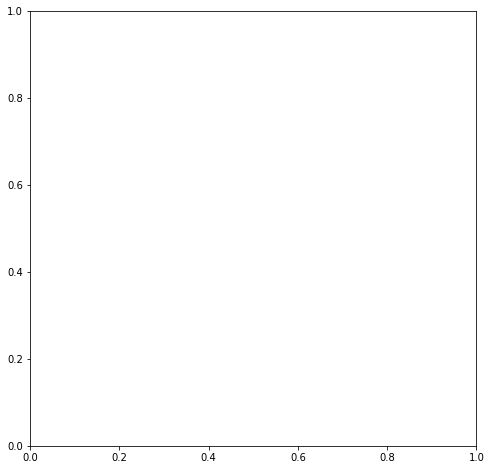

In [33]:
fig, ax = plt.subplots(figsize=(8,8))
cmap = cm.ScalarMappable(norm =plt.Normalize(min(Power[:,1]),max(Power[:,1])),cmap = 'copper')
cmap.to_rgba(45)
for i in range (np.size(fil,0)):
    data = io.imread(""+str(int(fil[i,0]))+"_" + str(fil[i,1]) +".tif")
    line = data[int(center[1]),:]*PMTconversion(fil[i,1],fil[0,1],3)
    intensity = Power[np.where(Power == fil[i,0])[0],1]
    ax.plot(line,color= cmap.to_rgba(intensity[0]),linewidth=1,label = ''+str(intensity[0]) +'uW')
plt.legend()
plt.xlabel("Pixel",fontsize = 18)
plt.ylabel("Intensity(a.u)",fontsize = 18)